In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [4]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)
gdf_5021 = gdf[gdf.Basin_Numb == '5-021'].copy()

In [12]:
minx, miny, maxx, maxy = gdf_5021.total_bounds

cell_size = 1000  # 1km = 1000 meters
grid_cells = []
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        grid_cells.append(box(x, y, x + cell_size, y + cell_size))
        y += cell_size
    x += cell_size

# Connect to the ipyparallel cluster.
rc = ipp.Client()  
dview = rc[:]  # Direct view to push variables to all engines.
lview = rc.load_balanced_view()  # Load-balanced view for mapping.

# Compute the union of all geometries.
area_union = gdf_5021.unary_union

# Use the direct view to push the union variable to all engines.
dview.push({'area_union': area_union})

# Define a function to check if a cell intersects the area.
def cell_intersects(cell):
    return cell.intersects(area_union)

# Map the intersection test in parallel.
intersection_flags = lview.map(cell_intersects, grid_cells).get()

# Filter grid cells that intersect the original geometry.
filtered_cells = [cell for cell, flag in zip(grid_cells, intersection_flags) if flag]

# Create a new GeoDataFrame from the filtered cells.
grid = gpd.GeoDataFrame({'geometry': filtered_cells}, crs=gdf_5021.crs)

/tmp/ipykernel_563440/3195400616.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_union = gdf_5021.unary_union


<Axes: >

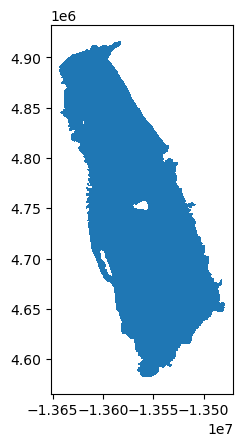

In [14]:
grid.plot()

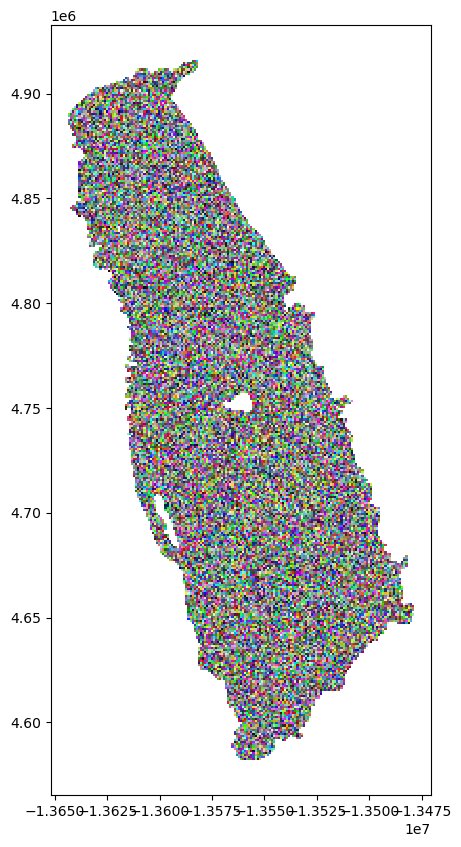

In [16]:
grid['color'] = ['#{:06x}'.format(np.random.randint(0, 0xFFFFFF)) for _ in range(len(grid))]

# Create a matplotlib figure and axes.
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each geometry using its assigned random color.
grid.plot(color=grid['color'], ax=ax)

plt.show()

In [18]:
simple_5021 = pd.read_csv("simple_5021.csv")

In [20]:
simple_gdf = gpd.GeoDataFrame(
    simple_5021,
    geometry=gpd.points_from_xy(simple_5021.longitude, simple_5021.latitude)
)

# Set the CRS to EPSG:4326 (WGS84) since you have latitude/longitude
simple_gdf.set_crs(epsg=4326, inplace=True)

# Reproject simple_gdf to match grid's CRS (EPSG:3857)
simple_gdf = simple_gdf.to_crs(grid.crs)

# Perform spatial join: for each point, find the grid square (polygon) it falls within.
# The joined GeoDataFrame will have an 'index_right' column corresponding to grid's index.
joined = gpd.sjoin(simple_gdf, grid, how='inner', predicate='within')

# Group by the grid square using the 'index_right' and calculate the mean gradient and median p_slope.
agg = joined.groupby('index_right').agg({
    'gradient': 'mean',
    'p_slope': 'median'
})

# Merge the aggregated results back into the grid GeoDataFrame.
grid = grid.merge(agg, left_index=True, right_index=True, how='left')

In [26]:
grid["ones"] = [1 for _ in range(len(grid))]

In [27]:
grid

,geometry,color,gradient,p_slope,ones
0,"POLYGON ((-13642725.157 4885007.747, -13642725...",#8c6a18,NaN,NaN,1
1,"POLYGON ((-13642725.157 4886007.747, -13642725...",#1a8ed1,NaN,NaN,1
2,"POLYGON ((-13642725.157 4887007.747, -13642725...",#cb43be,NaN,NaN,1
3,"POLYGON ((-13642725.157 4889007.747, -13642725...",#1eded1,NaN,NaN,1
4,"POLYGON ((-13642725.157 4890007.747, -13642725...",#9fdb09,NaN,NaN,1
...,...,...,...,...,...
26408,"POLYGON ((-13479725.157 4656007.747, -13479725...",#1e4793,NaN,NaN,1
26409,"POLYGON ((-13478725.157 4651007.747, -13478725...",#9fe6ab,NaN,NaN,1
26410,"POLYGON ((-13478725.157 4653007.747, -13478725...",#b17581,NaN,NaN,1
26411,"POLYGON ((-13478725.157 4654007.747, -13478725...",#b38d36,NaN,NaN,1


In [28]:
grid['centroid'] = grid.geometry.centroid

# Create a GeoSeries from the centroids and reproject to EPSG:4326 for lat/long values.
centroids_latlon = gpd.GeoSeries(grid['centroid'], crs=grid.crs).to_crs(epsg=4326)

# Add longitude and latitude columns using the reprojected centroids.
grid['longitude'] = centroids_latlon.x
grid['latitude'] = centroids_latlon.y

# Optionally, drop the temporary 'centroid' column
grid.drop(columns='centroid', inplace=True)

In [29]:
grid

,geometry,color,gradient,p_slope,ones,longitude,latitude
0,"POLYGON ((-13642725.157 4885007.747, -13642725...",#8c6a18,NaN,NaN,1,-122.559177,40.134507
1,"POLYGON ((-13642725.157 4886007.747, -13642725...",#1a8ed1,NaN,NaN,1,-122.559177,40.141374
2,"POLYGON ((-13642725.157 4887007.747, -13642725...",#cb43be,NaN,NaN,1,-122.559177,40.148241
3,"POLYGON ((-13642725.157 4889007.747, -13642725...",#1eded1,NaN,NaN,1,-122.559177,40.161973
4,"POLYGON ((-13642725.157 4890007.747, -13642725...",#9fdb09,NaN,NaN,1,-122.559177,40.168838
...,...,...,...,...,...,...,...
26408,"POLYGON ((-13479725.157 4656007.747, -13479725...",#1e4793,NaN,NaN,1,-121.094923,38.543616
26409,"POLYGON ((-13478725.157 4651007.747, -13478725...",#9fe6ab,NaN,NaN,1,-121.085940,38.508477
26410,"POLYGON ((-13478725.157 4653007.747, -13478725...",#b17581,NaN,NaN,1,-121.085940,38.522535
26411,"POLYGON ((-13478725.157 4654007.747, -13478725...",#b38d36,NaN,NaN,1,-121.085940,38.529563


In [30]:
grid.to_file('grid.gpkg', layer='grid', driver='GPKG')